In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import PIL.Image
import functools 
import IPython.display as display

In [0]:
class Image_Utils():

  @staticmethod
  def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

  @staticmethod
  def download_img(img):
    file_name = 'stylized-image.png'
    img.save(file_name)

    try:
      from google.colab import files
    except ImportError:
      pass
    else:
      files.download(file_name)

  @staticmethod
  def constrain_img(img,max_dim=512):
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

  @staticmethod
  def show_img(img,title=None):
    if not(isinstance(img,PIL.Image.Image)):
      if len(img.shape) > 3:
        img = tf.squeeze(img, axis=0)
    if title != None:
      plt.title(title) 
    return plt.imshow(img)
    

  @staticmethod
  def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
    
  @staticmethod
  def clip_0_1(clip_image):
      return tf.clip_by_value(clip_image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def vgg_19_custom_model(self,layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model
    
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  self.vgg_19_custom_model(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def gram_matrix(self,input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [self.gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [0]:
class NST():
  def __init__(self,content_img,style_img,style_w=1e-2,content_w=1e4,total_loss_var_w=30):
    self.content_img = content_img
    self.style_img = style_img
    self.style_w = style_w
    self.content_w = content_w
    self.total_loss_var_w = total_loss_var_w
    content_layers = ['block5_conv2'] 

    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1']

    self.content_l_len = len(content_layers)
    self.style_l_len = len(style_layers)
    self.extract_from_vgg = StyleContentModel(style_layers, content_layers)

  def calculate_loss(self,outputs): #outputs is a dicionary returned by outputs_from_vgg
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - self.style_target[name])**2)  for name in style_outputs.keys()])
    style_loss *= self.style_w/self.style_l_len

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - self.content_target[name])**2) for name in content_outputs.keys()])
    content_loss *= self.content_w/self.content_l_len
    loss =style_loss+content_loss
    return loss

  @tf.function()
  def train_step(self,image,optimizer):
    #feedforward
    with tf.GradientTape() as tape:
      outputs = self.extract_from_vgg(image)  
      loss = self.calculate_loss(outputs)
      loss += self.total_loss_var_w*tf.image.total_variation(image)
    #backprop
    grad = tape.gradient(loss,image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(Image_Utils.clip_0_1(image)) 
      
  def predict(self,epochs=5,epoch_steps=100): 
    #Targets of each image, which will be used for calculating the loss
    #which will be used to optimize the image with an Adam optimizer
    self.style_target = self.extract_from_vgg(self.style_img)["style"]
    self.content_target = self.extract_from_vgg(self.content_img)["content"]

    image = tf.Variable(self.content_img)
    optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    for epoch in range(0,epochs):
      for step in range(0,epoch_steps):
        self.train_step(image,optimizer)
        print(".", end='')
      display.clear_output(wait=True)
      display.display(Image_Utils.tensor_to_image(image))
      print("Epoch: {}/{}".format(epoch+1,epochs))
    return Image_Utils.tensor_to_image(image)

In [5]:
#concha
content_path_concha = tf.keras.utils.get_file('content.jpg', 'https://lh3.googleusercontent.com/RNV_lUPwQSimZ0UaCBeLvSur0MWQ3hcJEffpbRYgbVpkISaOo8Ub2PxF0mkl_9nrbXy12LE5tGmrcWW3NbOwXtCyQupAzrUfIyPwg9dVG-69fz5Haa-GlUuCUqCVBBx0fFMXasWqeqmV5cyDPwnJ4JwmTxaIra1jjmCxFE72Vm1V-mJP0mqJ82bXhsaQKfOOlKun-vznIYffnfcwX9ilaZgHgBursAbC_-qieA8zsYsPkkwAfXPIN-7WV-owP60EtYht_TH1axXx1gpPlJlOD3fel-Lfny7-tYVZxObn-ILtzQZrmgIM_iUUNxhoCMqCa7I6YuuRRT8pfbRzy5Cm_X--Ok0yyZepLuDhQaIGoNwfIh1ZLU4Qfp5daX97C64NcYmcC2yhUb9TvnlP55c6XsPB5JQywg2OZJxMxrRNwOPAWyw9Z5JFMsv9CNn8rS2Lv8I0MORf1dJ8HIiBdBpimwm5j11mOreyn13baIptoj9oOV0dWVDEq57unL66NqNLTHVEyWnGgXA90goR-SzYfFaKODci-M7OKqlTOenKulvDQ2vU900lIHxmCJAINO1kswz7F5fV8X9o-8KLEz8tQjVuIlSkAmbj7IR9PVoHi5tbWUh-uScJEZYaJHUpr6Rl-hWnpMX5_Ec7QAEH4AMr_U1xlZSCR9INQswAzRoK-1c0qOpIvq3faERjTwFM1qowlhsfBN19mA-9kH0VOVC6_fKYjvJgEMKrd6OfGgxyqlQgQLrBsGTvJqc=w1636-h920-no')
#pascoa
#content_path = tf.keras.utils.get_file('content.jpg', 'https://lh3.googleusercontent.com/EYcDmqAI-yke1CuM6UAq3uatHa6U9GGRJwD1d-uLE7uaiCD2GF36ki-zPqTC0NBIOLOForypitnug6nfcs2ok95LMqG05YOISFhkQeoYuHAIJ9ZWeO4rn3DfW3hgbvHrVbRPMef_Lh4ujpXd6ALxpw7FtTQCSfeo9wIYQpflj8vztXe3xZm3k4xwchq_E9iJBuj9u1JwfV8EQIfh9bJ4knvDAsrP7KspRXKcA3875n4-GuAgsqESkuHKwpLdKX0Sio27Qb8IOMgdv8NIjknSCumu7r6Y_t3aorA0RrFC96W30IISeixc2C0XIijO57sqJFEwXU4rrIoYax8TiHhR4foJt2g9liQ7vm3IaqgCwZH22T8AFS7uYl1yOISZeKEl-Uve8nbIiAZ8eevTIxuzPWto6KiEQz_MGc6nQ-r_UpS2NfftNmwWMvPhQPTGty06foLK5snCRcnKspfNKMKLBG5l_IZEjFCPqsuNNeXys_441g-6QULKbtjJaTThWyAatzWIAUCvfqSQO3FeQF8GurpuDxTtfabEipubVNGLDi7k1ZOw0A4kdiV67KByBOjBp_TMgVy-HO0DmHn-rM27AJ4c4m6WNVrmHHs6eRTK86QC-LkDVVKS9ce1eSybyxEtFA9kW6cEwu5OUqeAu65q31j5iFsOu3LcZJEXdHV-OUrXvG5RDpLdLSR9cDVvGvoPFL8nQTfQuoKe2g8EQDKebhiFg0Vt4NXtd-8KIebdgnb7gZ-d7vZH-Ds=w551-h736-no')
#champo
#content_path = tf.keras.utils.get_file('content.jpg', 'https://lh3.googleusercontent.com/PZ1KDjL6OdvBp6Qf1jyoScwRdFrj3vmpgn3m6CH8KgHeZYMHBIHuUaIjmO7PXdG3Q6p4AbGxGs8wVt1V60o0qM90kfHY3i4bIDXAsQGTOHkuVlJ7x4idgP780gWcOccDUNn9kezhBeD96DKp24lib7pYMQ0ys2Y74WG-R7kk83yQsShonz-F7bOF9_Pi8LligcNQcZ3au5edojfAqZ-0lsvy_pRN75Gl2IDShTossLXckGKUwqI0bAD6gOnwajAVkzhH8IsGYHMFoNrPHqbW-vBDeJNVnZ-q11O2DLKwniQnhOkq5stiHo5IFIKnr1BlxlyQ-VGpYw8xkyFkgBdKrTk1ew0SRcx2Ew4mQWYiVAmGYTQs7TFrkuXAZtBVq0jlo-5gdgWeGqlEqTWb2WYoAHIO8KdsCYMpLqSZK0gM3t3SzBHysLgrkwQq1HcmG_OKUNhw9Y2tw6vNnSNcPtWs_ONWZ9rqIsBcnMzvgZlWcT_BoQxvomDkOURMZJ1Suxu5dqlk5-ntEDaCP6H2-QHIdH281zH9ovHE7WxFak8yiX1Ftxm6vHc2srC8NfLIlNSu8NMZ1Lov_OVcnJiHimBfUSOaVTyNPfI1EyYUgWeOnC-BFJyFj2opAaN2f4zod2Pazt_t8eKKFiJpizr__7mWYMsyldQ8vSXJB31RxbrlXB99u6Piz0JNoC_tsfiOvUQCzouFaqy5nHthDLwQX5rdWSg6G_dLONHAxj5m0lYRdXCZwwvspgmY-Q0=w448-h969-no')
#dog
#content_path = tf.keras.utils.get_file('content.jpg', 'https://lh3.googleusercontent.com/IOSYzRY6QkHhbLlmqr981478vxxroXvWlxL_8gc9dDvd3plFZCj1aQp_SgGnp24nHLqvEDPDf0zl9fqmeXnMIUnCoJ0x3p2kUqiTMAP78iYHNKWbobW6u7Z5tjErle1W5bWmzygeHm6SXVXXEwso1K4h-A3QftI2Bl4vKgJIRS8-Ej_BJ_no_YnVk9uelzsoEKdedaRpAR0wDUE_HYrMGfysPWydEgFbdMHFUXH8tSiw2vslPHobt9IkdMwD7-dCi2Mz0lruWWSMOJ5vYVLPSf6cAy2FsCSnLo2FraqyL7MmRLSSMH3J3tjOrJQ8nUtnBskuFLK8wIn54Zs3Hf643MVxl3snyiQkjt5wU5oCoMbhcv4WdZrMR27vXLyDS1BxF0unmqR5u267Z-WoVt-9Bdhgu7N5bHso7acVLHoWIgmy8yfGPbJWGpib7U2svzPIGj_AO_8rV7kylxkA4LjhwgobLFhFRhhwxzAkiFmPPc9nH0VIZ4PhVzpOHD5jEMJjApjd8R5C4BG3VPjOPS6OoFMqOytbaHlEhYP_XNIbcl2Tmwsp9XZcKPUbFVejFerkDnJIJ-ArcSpvBnetmeiPFWMtRbYh4bErUxoaIKsbqPcO-fnauw1hSbXaxCjfMDJVPlSRCkaJIZW7n9CoofmhOLqH1Bqvqg4skUyG56pyT-t0949ygLGFrXOXqtC994QelIleWYuPt5YxEoRygh5S6QN3omsq4r9c0JIty-ts2d0FtO2z9XdPqbE=w591-h406-no')

#irma
content_path_irma = tf.keras.utils.get_file('irma.jpg', 'https://lh3.googleusercontent.com/UE36TY-hztlweMLgLrvEMMmllBdCwRUNaG-sAbW4o_BVhQPua_9dr8doqybQYc0AzT4EV-71q8mlBmab5Mc9iYurExMQEZd2LJSTYddA7Xi3eZNU1gA4z9etz0cx22_DXvZMk5dDK7dC0R2Ngw4eH9TzMzX0ttwpjOwPbU5Y5f6A80-7dOGW1KevEHwIIi0tC3_ScPVR2P2hmlFAITmaR1pgs5igXVxRsukoIo9QwyZFdix2q8fLVTX_CnroYw_sUYYbP_-obM7cQaC7UzdaZyNwaxLpQcPE7K8Y6pI2jxwSt1i4X_4vLMOkqyoWhzNiygLweJcONzPGSMVGmmIGkJQ_L339A8nRUWHafKApAcK23Z_pmCyHepHguuyeLcur8gzBlJd3W5Bzxt-L4O7f9t1Dfjs3nrdLID3phf3R7KtnqHRDMW4fVO_GvvpkV_3Dsc1S-ANYT4TZVDOND7kvwrthJyhWvshWBrPfcJy93zd4o9LDUQQeiQCfPdTK9JXaHbekurhWdjy7Lw6KoZ6DZDFISccq3NWcQyeApuE5HihaI033J2MPk_w8AVnBfgqJuRrI8bjDTVGuKwTGPDDfGB_8yYODT407290gs8sl2NDwdSoUQJ1eBYIajgvmy7vLX2Vsz08akZy5JsICHpt9VtbsThaJp_8F2dXPRHiqIi9wkOK26U1790slMKuWN0XnxrQ5UyqNyXRvIPVPaOrHhe-w61iJeePw6JmLYD0cfvge39990CDxBqk=w727-h969-no')
#bia
content_path_bia = tf.keras.utils.get_file('bia.jpg', 'https://lh3.googleusercontent.com/3qT4kK1JDtSKKUt_kwT7kYW7a73BcwL3A3yOXLul_YAiIuKC82XX9dVXnI-8IMTa1SWO7OmOGGLfpQwxeKmK25A23Oq72QKvQzY6cLJPumsP31-tbp2DLLG9IJDqXwNEPXr_qsVowxTEOOcZqI2sEcEjTNQ_OJImCwHa-603sOkZBjJ-N7-JcYnup1FsrrXahTioC-brCOhKxZuA42-RU4CqRao9jFOWR3_lFwbCTEDhtp4_9aIXJkUianw6mOlL5ktqIrgtbh6RnAOky7QQbANsrASln_YYymkgJLqaKVfv2Zp98X888mXZNhcKyut0uTQXHCsnr7EBX_BjYJ3U01XSEMc4dBNTR2oYlxxOULXzk-iBOQ5w7OupDhlpQL6m2cfItwmSxOz6lNVlPNk17t85THCww5YVbKpRVATFxkyzsB9ZevCQf_VbZy12VTJCVCu7twVaLiJJ_dmhGcWKuvxNqJCo1Pb8SGd5OhwGrQtde_SyKiof_Be6C461bt-qosVQOYzUqhfCb9Zg8OW2hjqOWdNdi_nuO8DUkfEVauCA3Hw5jcWzlMlaxpRU6G6UdXg9pTi5XwvGYlHgXT7BKfEVvna9R6q6V8sHm4blfIoo3sZqjnmgPLTJ-iYcTU50tGRt6HqWikHJtEnpRLVKeh7q-ZICILSoh856-qjbysI-BCURNFGK2EJtxWOYgqq5ir4uuH4wM4YAuPzg9AwMFLq-y-IyK5bnMGCnCDVm_20gglo2SE9nz1A=w1280-h960-no')
#amigo da irma
content_path_am_irma = tf.keras.utils.get_file('amirma.jpg', 'https://lh3.googleusercontent.com/aUkyLLYe28QOi86KVqVcII-7RHrNuoppNDnnqm7NPVYGb5vX_DMUsF45CDfE9laZoCNUjMA0tySS5P7IwyboGb7PBUPTb6EgtkvuFXqZtULkfp-OnU9VB5pCIaCQsX4PRTnw1Y6tfQ_TOTGC1fcc5SxbF2dek_nxxd3L5rIChSpZBC7SBC3j6_AusV4vYB_VC5bzURwk9xD78yM9lQnyKAQlOXdDn0v1FkVeOu8WPanuK33FjtKCgTwm9zrkg7cT4MUOCjNjBzH9-As-PuDZ5ADj48KPrVzdCARTzmJwD6BpuvJAkYqQBG4EOWUbujx0riR2VpvYQ89rD2U9yihp1wdZjFFTEyhiVJYkpTNbTtLP7a8x5dFI-aDosBF-dzqqrInHT5T-imxMj3YbDKpBXR-fGIbKLZJB2cLSbyByG6dE1gScixmDbn3twLA-seQTVq2R6DFSu6QpgAxFy6ERytrNYTrZDIE2_nymf8ALA9pZ7BkeTTVCSXa5MMI2VKtq2u8EbRglYZUlgFX5OOJhi61c5LHqCIIpXFoglomPo035SOxA9640f6gtOWjM_Su_QLso2l417BKPUTw6GfeMeY46EkFgO8oXrFtwcGlNThNDDIrdqMxJZSuKDqp0NXHSMzNTnygxrDaHPKhx6k4GNco5ux6ToZVc0drLot8TZkTTsz2C_q1MuCh6EkhDdoSYTYvu7xO1sCZ6-XR8kcnhwX6SWvigsPTmVZ-N9jHQsWEsdni7WF3WXfk=w545-h969-no')



#kindansky
style_path_kin = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
#van gogh
style_path_van = tf.keras.utils.get_file('van.jpg','https://img.rawpixel.com/s3fs-private/rawpixel_images/website_content/pdvangogh-snvgrob.jpg?auto=format&bg=transparent&con=3&cs=srgb&dpr=1&fm=jpg&ixlib=php-3.1.0&mark=rawpixel-watermark.png&markalpha=90&markpad=13&markscale=10&markx=25&q=75&usm=15&vib=3&w=1400&s=0edc8389ab57fd36c213b4422965ecc6')
#seated nude picasso
style_path_pic = tf.keras.utils.get_file('picasso.jpg','https://art-picasso.com/image/1910/1910%20Seated%20female%20nude%2092x73cm%20Tate%20Gallery,%20London,%20UK.jpg')

483328/481148 [==============================] - 1s 2us/step


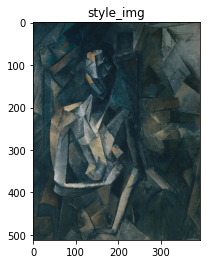

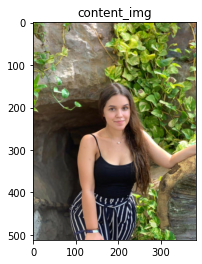

In [6]:
style_img = Image_Utils.constrain_img(Image_Utils.load_img(style_path_pic))

content_img = Image_Utils.constrain_img(Image_Utils.load_img(content_path_irma))

Image_Utils.show_img(style_img,title='style_img')
plt.show()
Image_Utils.show_img(content_img,title='content_img')

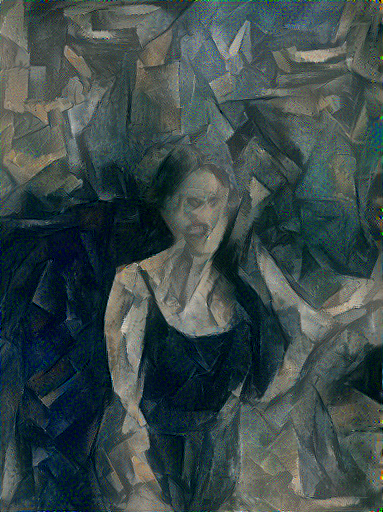

Epoch: 100/100


In [7]:
nst = NST(content_img,style_img,style_w=1e2)
image = nst.predict(epochs=100)